# Projet Stratégies d'Investissement Alternatives et Quantitatives
## Jérémy Bellina, Joël Zhu

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Data

In [2]:
# load the crypto prices csv data
crypto_prices = pd.read_csv("crypto_prices.csv", parse_dates=[0])
crypto_prices.set_index('date', inplace=True)

# load the CRIX index csv data
crix_prices = pd.read_csv("vcrix.csv", parse_dates=[0])
crix_prices.set_index('date', inplace=True)
crix_prices = crix_prices.drop(["Unnamed: 0", "n"], axis=1)
crix_prices = crix_prices.loc["2018-04-01":]

# load the Fama & French momentum factor csv data
FFMomentum = pd.read_csv("F-F_Momentum_Factor_daily.CSV", parse_dates=[0])
FFMomentum = FFMomentum.rename(columns={'Unnamed: 0': 'date'})
FFMomentum.set_index('date', inplace=True)
FFMomentum = FFMomentum.loc["2018-04-01":]

# load the Fama & French research data factor csv data
FFResearch = pd.read_csv("F-F_Research_Data_Factors_daily.CSV", parse_dates=[0])
FFResearch = FFResearch.rename(columns={'Unnamed: 0': 'date'})
FFResearch.set_index('date', inplace=True)
FFResearch = FFResearch.loc["2018-04-01":]

In [3]:
formatted_dates = pd.date_range(start = "2018-04-01", end = "2020-05-26")
rebalancing_dates = pd.date_range(start = "2018-04-01", end = "2020-05-01", freq = pd.DateOffset(months=1, day=1))
horizon = 15
initial_value = 100

# Helper functions

In [4]:
def sort_returns(current_date, data):
    date = str(current_date.date())
    return data.loc[date].sort_values(ascending=False)

In [5]:
def compute_value(date, portfolio, crypto_prices):
    value = 0
    for item in portfolio:
        value += item[1] * crypto_prices.loc[date, item[0]]
    return value

In [6]:
def update_portfolio(amount, data, date, crypto_names):
    portfolio = []
    for name in crypto_names:
        portfolio.append((name, amount / data.loc[date, name]))
    return portfolio

# Backtest functions

Creates portfolio long on all crypto currencies **equally weighted**

In [7]:
def get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, data, portfolio_index):
    values = [initial_value]
    returns = data.pct_change(periods=horizon)
    portfolio = []
    for date in formatted_dates:
        if str(date) != "2018-04-01 00:00:00":
            values.append(compute_value(date, portfolio, data)) # update values
        if date in rebalancing_dates:
            sorted_returns = sort_returns(date, returns) # sort returns for the rebalancing date
            crypto_names = sorted_returns.iloc[(10 * (portfolio_index - 1)):(10 * portfolio_index)].index # extract names from data
            portfolio = update_portfolio(values[-1] / 10, data, date, crypto_names) # update composition
    return values

Creates a portfolio **long on best returns** crypto currencies and **short on lowest returns** ones

In [8]:
 def long_short_strategy(ptf_values1, ptf_values5):
    values = []
    for value1, value5 in zip(ptf_values1, ptf_values5):
        values.append(value1 - value5)
    return values

# Portfolio initializations

In [9]:
# P1, P2, P3, P4, P5
portfolios_df = pd.DataFrame()

portfolios_df["Date"] = formatted_dates
portfolios_df.set_index('Date', inplace=True) # set as index so that it is easier to plot

for i in range(5):
    pf_index = 1+i
    portfolios_df["P"+str(pf_index)] = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, pf_index)

In [10]:
# Long-short strategy
ptf_values1 = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 1)
ptf_values5 = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 5)
long_short = long_short_strategy(ptf_values1, ptf_values5)

long_short_df = pd.DataFrame(data = {'Date': formatted_dates, 'P1-P5': long_short})
long_short_df.set_index('Date', inplace=True)

# Plot 

<AxesSubplot:title={'center':'Values of P1, P2, P3, P4 P5'}, xlabel='Date'>

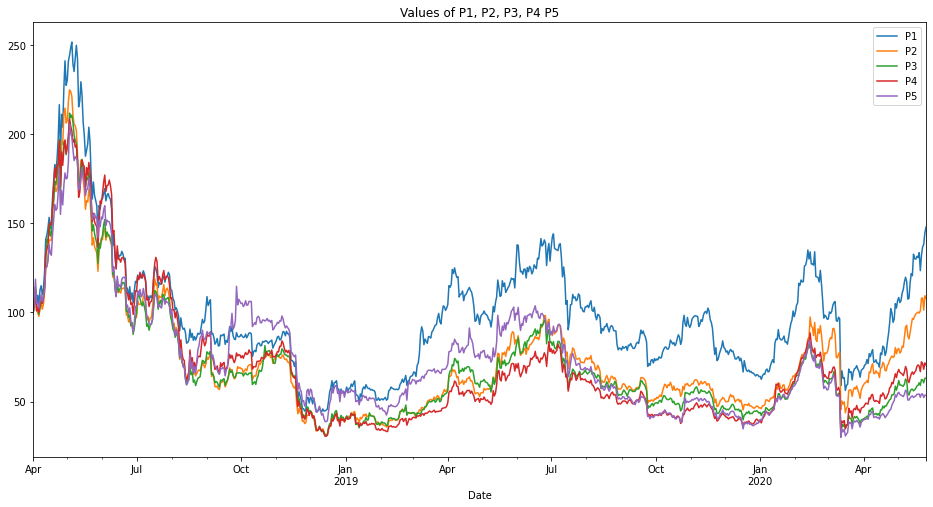

In [11]:
portfolios_df.plot(figsize=(16,8), title="Values of P1, P2, P3, P4 P5")

<AxesSubplot:title={'center':'Long-short strategy (buy P1 sell P5)'}, xlabel='Date'>

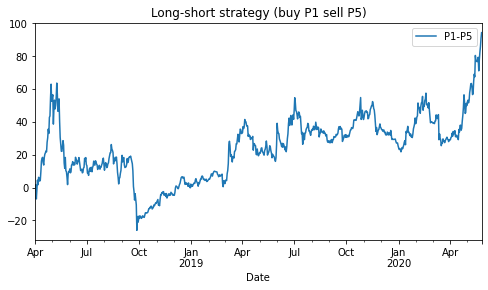

In [12]:
long_short_df.plot(figsize=(8,4), title="Long-short strategy (buy P1 sell P5)")

# Statistical description

## Initialization

In [13]:
# P1 to P5
portfolios_df_returns = portfolios_df.pct_change()

In [14]:
# Long-short strategy
long_short_df_returns = long_short_df.pct_change()

def winsorizing(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    minimum  = q1-1.5*iqr
    maximum = q3+1.5*iqr
    return df.loc[(df[col] > minimum) & (df[col] < maximum)]

long_short_df_returns = winsorizing(long_short_df_returns, 'P1-P5')

## Mean

In [15]:
# P1, P2, P3, P4, P5
portfolios_df_returns.mean()

P1    0.001651
P2    0.001213
P3    0.000491
P4    0.000686
P5    0.000440
dtype: float64

Interprétation : Le rendement moyen journalier du portefeuille P1 est 0.165%. Il est plus élevé que tous les autres portefeuilles momentum. Cela est cohérent car le portefeuille P1 est constitué des crypto-monnaies ayant la plus forte croissance à chaque date de rebalancement. Il semble donc que la stratégie momentum fonctionne.

In [16]:
# Long-short strategy
long_short_df_returns.mean()

P1-P5    0.00499
dtype: float64

Interprétation : Le rendement moyen journalier de la stratégie 'acheter P1 et vendre P5' est proche de 0.5%. Cela est beaucoup plus élevé que le rendement moyen de P1. C'est un signe positive qui indique que la stratégie semble fonctionner.

## Standard deviation

In [17]:
# P1, P2, P3, P4, P5
portfolios_df_returns.std()

P1    0.047095
P2    0.046147
P3    0.045343
P4    0.046768
P5    0.048832
dtype: float64

Interprétation : Les écart-types ne sont pas significativement éloignés les uns des autres pour pouvoir dire qu'un portefeuille est plus risqué qu'un autre. On peut donc supposer que les portefeuilles de crypto-monnaies sont tous exposés à un risque de marché similaire important (celui des crypto-monnaies) mais que les portefeuilles sont suffisament diversifiés au sein de ce marché pour ne subir qu'un risque spécifique faible.

In [18]:
# Long-short strategy
long_short_df_returns.std()

P1-P5    0.09213
dtype: float64

Interprétation : L'écart-type de la stratégie est presque 2x plus élevé que le portefeuille P1. On peut donc expliquer en partie le rendement plus élevé de cet stratégie par un risque beaucoup plus grand.

## Median

In [19]:
# P1, P2, P3, P4, P5
portfolios_df_returns.median()

P1    0.003487
P2    0.002854
P3    0.002478
P4    0.003057
P5    0.003053
dtype: float64

Interprétation : Les médianes sont bien plus élevées que les moyennes. Les rendements journaliers négatifs sont donc beaucoup plus importants en valeur absolue que les rendement positifs.

In [20]:
# Long-short strategy
long_short_df_returns.median()

P1-P5    0.005939
dtype: float64

Interprétation : La médiane est plus élevée que pour le P1. Cela semble cohérent avec le fait que la rentabilité moyenne soit également plus élevée.

## Minimum

In [21]:
# P1, P2, P3, P4, P5
portfolios_df_returns.min()

P1   -0.388953
P2   -0.414802
P3   -0.398284
P4   -0.385747
P5   -0.426499
dtype: float64

Interprétation : Durant sa pire journée, le portefeuille P1 a subit une baisse de -38.90% de sa valeur. Cela est très important mais reste néanmoins légerement moins que les autres portefeuilles (à l'exception du P4).

Le rendement minimum est le plus faible pour le portefeuille P5. Le plus fort est celui du portefeuille P1-5 néanmoins, sachant que nous avons enlevé certaines valeurs extrêmes, ce résultat doit être relativisé.

In [22]:
# Long-short strategy
long_short_df_returns.min()

P1-P5   -0.243114
dtype: float64

Interprétation : Le minimum de la stratégie est plus faible que celui de P1. C'est un signe positif qui indique que cette stratégie permet d'amortir les variations fortes du marché. 

A noter : Ce résultat est à relativiser car on effectue une winsorisation qui élimine certaines valeurs extrêmes.

## Maximum

In [23]:
# P1, P2, P3, P4, P5
portfolios_df_returns.max()

P1    0.153043
P2    0.186089
P3    0.168602
P4    0.252157
P5    0.210899
dtype: float64

Interprétation : Durant sa meilleure journée, le portefeuille P1 a vu sa valeur monter de 15.30%. C'est impressionant mais plus faible que les autres portefeuiles qui atteignent jusqu'à 25.22%. Durant des périodes à fortes variations, le portefeuille P1 subit des gains et des pertes moins importantes que ses homologues. On pourra donc s'attendre à un Béta plus faible.

In [24]:
# Long-short strategy
long_short_df_returns.max()

P1-P5    0.257673
dtype: float64

Interprétation : Même avec la winsorisation, le maximum est nettement plus élevé que P1. C'est également un bon signe car cette stratégie permettrait donc d'amortir les variations à la baisse et amplifier les variations à la hausse.

## Skewness

In [25]:
# P1, P2, P3, P4, P5
portfolios_df_returns.skew(axis=0)

P1   -0.938847
P2   -1.129604
P3   -1.027596
P4   -0.639909
P5   -0.567365
dtype: float64

Interprétation : La skewness de tous les portefeuilles est négative. Cette statistique indique que la distribution est asymétrique et que la queue de la distribution est plus longue vers les rendements inférieurs à la moyenne. 
Pour les portefeuilles P1 à P5, la distribution est modéremment voir fortement skewed négativement.
Cela est confirmée par le fait que la moyenne est inférieure à la médiane. 

In [26]:
# Long-short strategy
long_short_df_returns.skew(axis=0)

P1-P5   -0.04049
dtype: float64

Interprétation : La skewness de la stratégie est proche de 0. La distribution est donc quasiment symétrique.
Cela est également logique car la différence entre la moyenne et la médiane est plus faible pour la stratégie que pour les portefeuilles individuels.

## Kurtosis

In [27]:
# P1, P2, P3, P4, P5
portfolios_df_returns.kurtosis(axis=0)

P1    7.182078
P2    9.462124
P3    8.739581
P4    8.008115
P5    9.388953
dtype: float64

Interprétation : Les Kurtosis sont plus grandes que 3. La distribution est donc leptokurtique qui indique qu'une grande partie des rentabilités est concentrée autour de la moyenne.

In [28]:
# Long-short strategy
long_short_df_returns.kurtosis(axis=0)

P1-P5    0.308785
dtype: float64

Interprétation : Le kurtosis est inférieur à 3. La distribution est platykurtique qui indique qu'il y a peu de valeurs extrêmes. 

# Performance measures

## Initialization

In [29]:
ptf_values1 = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 1)
ptf_values2 = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 2)
ptf_values3 = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 3)
ptf_values4 = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 4)
ptf_values5 = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 5)

all_ptf_values = pd.DataFrame(data = {'date': formatted_dates, 'P1': ptf_values1, 'P2': ptf_values2, 'P3': ptf_values3, 'P4': ptf_values4, 'P5': ptf_values5})
all_ptf_values.set_index('date', inplace=True)

all_ptf_pct_change = all_ptf_values.pct_change()
all_ptf_rets = 1+ all_ptf_pct_change
all_ptf_rets.iloc[0,:] = 1
all_ptf_rets = all_ptf_rets.cumprod()

## Sharpe

In [30]:
P1_num = (all_ptf_rets["P1"] - FFResearch['RF']).dropna()
P1_denom = np.std(all_ptf_rets["P1"])
print(np.mean(P1_num)/P1_denom)

P2_num = (all_ptf_rets["P2"] - FFResearch['RF']).dropna()
P2_denom = np.std(all_ptf_rets["P2"])
print(np.mean(P2_num)/P2_denom)

P3_num = (all_ptf_rets["P3"] - FFResearch['RF']).dropna()
P3_denom = np.std(all_ptf_rets["P3"])
print(np.mean(P3_num)/P3_denom)

P4_num = (all_ptf_rets["P4"] - FFResearch['RF']).dropna()
P4_denom = np.std(all_ptf_rets["P4"])
print(np.mean(P4_num)/P4_denom)

P5_num = (all_ptf_rets["P5"] - FFResearch['RF']).dropna()
P5_denom = np.std(all_ptf_rets["P5"])
print(np.mean(P5_num)/P5_denom)

2.691208789081393
2.1748405573654415
2.044919205273068
1.8709132648534677
2.21851825983589


## Treynor

In [31]:
R_Rf = (all_ptf_pct_change["P1"] - FFResearch['RF']).dropna()
crix_rets = crix_prices.pct_change()

Rm_Rf = (crix_rets["vcrix"] - FFResearch['RF']).dropna()

print(R_Rf)
print(Rm_Rf)

intercept = sm.add_constant(Rm_Rf)
reg = sm.OLS(R_Rf, intercept).fit()

print(reg.summary())

date
2018-04-02    0.059990
2018-04-03    0.039940
2018-04-04   -0.074984
2018-04-05    0.045866
2018-04-06   -0.057158
                ...   
2020-04-24    0.069282
2020-04-27   -0.052411
2020-04-28    0.019080
2020-04-29    0.090516
2020-04-30   -0.023911
Length: 525, dtype: float64
Series([], dtype: float64)


ValueError: zero-size array to reduction operation maximum which has no identity

## Jensen